# Notes
Once the mounting above is complete, I'm thinking we manage our directory like:
- `models/` - maybe we can just store our models here?
- `results/` - any output statistics/graphs to visualize our results
- `utils/` - assuming we'll have at least some utility helper functions/classes

# Step 0a. Initial Setup

# Step 0b. Dependencies/Imports

In [1]:
from networks.FasterRCNN import FasterRCNN
from networks.MaskRCNN import MaskRCNN
from utils import AnchorBoxUtil, DataManager, ImageUtil, TrainingUtil
import torch
import torch.nn as nn
import gc

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = 'cpu'
print('Current device is: {}'.format(device))

Current device is: cuda


# Step 0c. Data Preparation

In [3]:
# data parameters
dataset_name = "voc-2007"
num_train = None
num_val = None
h_img_std = 480 # standard image height to resize to
w_img_std = 640 # standard image width to resize to

# # initial import from fiftyone.zoo
# dataset_train = foz.load_zoo_dataset(
#     dataset_name,
#     splits=["train"],
#     max_samples=num_train
# )
# dataset_val = foz.load_zoo_dataset(
#     dataset_name,
#     splits=["validation"],
#     max_samples=num_val
# )

# load images into tensors and parse out the target information (bounding boxes and labels)
data_train, data_val, str2id, id2str = DataManager.load_data(dataset_name, num_train, num_val, (h_img_std, w_img_std))

Split 'train' already downloaded
Ignoring unsupported parameter 'label_types' for importer type <class 'fiftyone.utils.data.importers.FiftyOneImageDetectionDatasetImporter'>
Loading existing dataset 'voc-2007-train-None'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Split 'validation' already downloaded
Ignoring unsupported parameter 'label_types' for importer type <class 'fiftyone.utils.data.importers.FiftyOneImageDetectionDatasetImporter'>
Loading existing dataset 'voc-2007-validation-None'. To reload from disk, either delete the existing dataset or provide a custom `dataset_name` to use
Pre-processing [Validation] Dataset: 100%|██████████| 2510/2510 [00:21<00:00, 116.97it/s]


# Step 0d. Examples

## Example Using ImageUtil

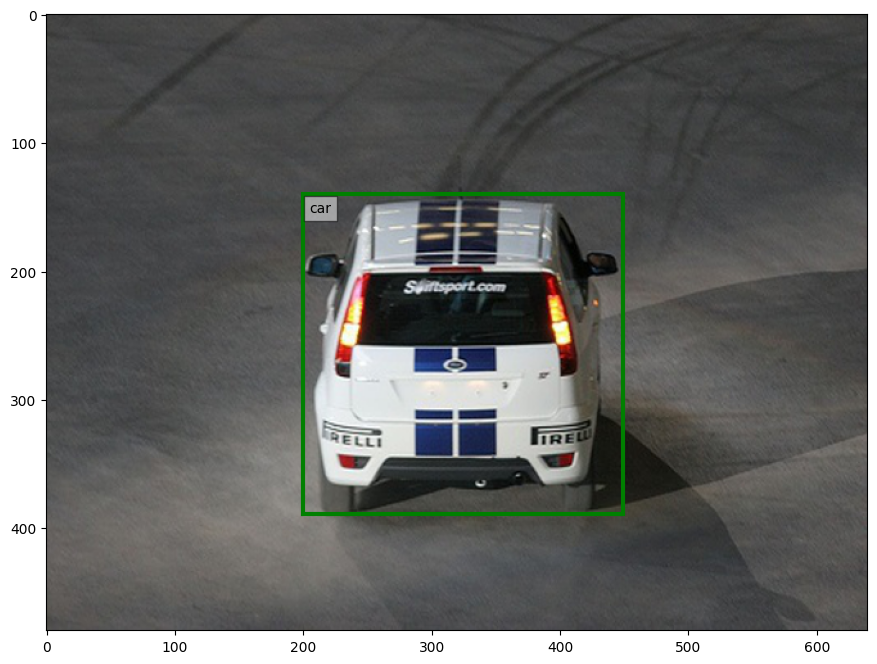

In [4]:
# data visualization tool
# session = fo.launch_app(dataset_train)

# example for using ImageUtil
example_idx = 0
# id_cats = {cat_ids[key]: key for key in cat_ids.keys()}                            # reverse the category ids
example_image = data_train.images[example_idx].long()                              # look up the image and convert to long
example_labels = [id2str[key] for key in data_train.labels[example_idx].tolist()] # get the actual label string(s)
example_bboxes = data_train.bboxes[example_idx]                                    # get this sample's bounding box(es) (format is: [x_min, y_min, x_max, y_max])
ImageUtil.build_image(example_image, example_bboxes, example_labels, 'g')

## Generating Positive/Negative Anchors

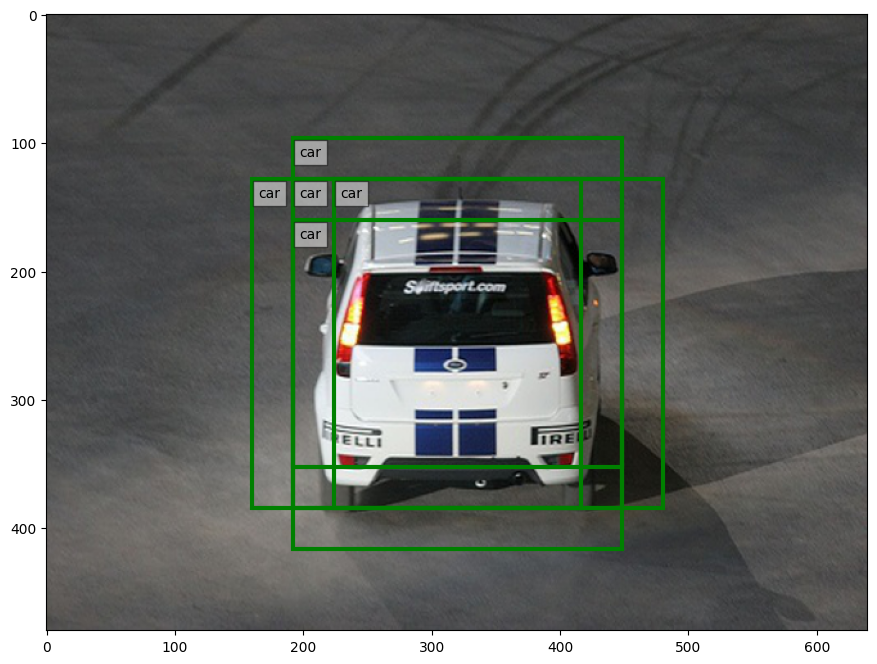

In [6]:
# generate anchor boxes
scales = [64, 128, 256, 512]
ratios = [0.5, 1, 2]
batch_size = data_train.images.shape[0]
features = torch.randn((batch_size, 1024, 15, 20))
anchor_bboxes, _ = AnchorBoxUtil.get_anchors_batch(data_train.images, scales, ratios, features, device='cpu')
train_bboxes = data_train.bboxes

# evaluate for positive and negative anchors
pos_thresh = 0.7
neg_thresh = 0.3

pos_coord_inds, neg_coord_inds, pos_scores, pos_classes, pos_offsets, pos_anchors = AnchorBoxUtil.evaluate_anchor_bboxes_alt(anchor_bboxes, train_bboxes, data_train.labels, pos_thresh=0.7, neg_thresh=0.3, output_batch=256, pos_fraction=0.5)

top_n = 10
pos_classes = pos_classes[example_idx][:top_n]
pos_bboxes = pos_anchors[pos_coord_inds == example_idx][:top_n]

# display positives
lab = [id2str[i] for i in pos_classes.tolist()]
ImageUtil.build_image(example_image, pos_bboxes, lab, 'g', show=True)

# Step 1. Faster R-CNN

## Step 1a. Initialize Model

In [4]:
# parameters
img_size = (h_img_std, w_img_std)
roi_size = (3, 3)
n_labels = len(str2id) - 1
pos_thresh = 0.7
neg_thresh = 0.3
nms_thresh = 0.7
top_n = 128
hidden_dim = 512
dropout = 0.2
backbone_size = (1024, 30, 40)
backbone = 'resnet50'

model = FasterRCNN(img_size, roi_size, n_labels, top_n, pos_thresh, neg_thresh, nms_thresh, hidden_dim, dropout, backbone, device=device)

## Step 1b. Training

In [ ]:
# parameters
learning_rate = 1e-3
momentum = 0.9
num_epochs = 20
batch_size = 10

# initialize optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

# initialize scheduler
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [11], gamma=0.1)

# run training
loss_results = TrainingUtil.train_model(model, optimizer, scheduler, data_train, data_val, num_epochs, batch_size, id2str, device=device, save=True)

------------------------------------------------------------
Running Epoch: 01 / 20
Running Validation: 100%|██████████| 251/251 [01:14<00:00,  3.35it/s]
{1: 0.0, 2: 0.0, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.004920532741508769, 8: 0.0, 9: 0.0, 10: 0.0, 11: 0.0, 12: 8.866505887359909e-06, 13: 0.0, 14: 0.0, 15: 0.007243602843574096, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.0, 20: 0.0, -1: 0.0}
  Training Loss: 1.12, Validation Loss 0.71, Validation mAP 0.0580
------------------------------------------------------------
Running Epoch: 02 / 20
Running Validation: 100%|██████████| 251/251 [01:13<00:00,  3.40it/s]
{1: 0.0, 2: 0.0034261751196942476, 3: 0.0, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.0008236846111183976, 8: 0.002210938753132718, 9: 0.0, 10: 0.0, 11: 0.0, 12: 0.001031949490423312, 13: 0.010004459331248427, 14: 0.0023064908492581976, 15: 0.005599987732238994, 16: 0.0, 17: 0.0, 18: 0.0, 19: 0.00022201740974131707, 20: 0.0, -1: 0.0}
  Training Loss: 0.83, Validation Loss 0.67, Validation mAP 0.1220
---

In [8]:
model.load_state_dict(torch.load('G:\\Dropbox (GaTech)\\CS7643_DL\\Mask_R-CNN\\results\\models\\2024-04-20_165658\\model.pt'))

<All keys matched successfully>

## Step 1c. Evaluation

In [21]:
model.eval()
proposals, labels = model.evaluate(data_val.images[0:10].to(device), device=device)

[tensor([[428.0947, 480.0000, 517.2065, 480.0000],
        [ 74.1789, 335.2174, 422.5404, 406.0497],
        [526.7982, 477.3463, 640.8283, 480.0883],
        [640.0000, 459.0933, 640.0000, 465.6479],
        [439.8308, 480.0000, 542.0639, 480.0000],
        [328.6382, 480.0000, 642.2781, 480.0000],
        [453.4618, 471.7972, 641.3649, 480.2728],
        [ 94.2735, 480.0000, 604.6069, 480.0000],
        [ 19.3950, 315.3190, 364.8580, 376.1980]], device='cuda:0',
       grad_fn=<IndexBackward0>), tensor([[ 51.5638, 128.7366, 652.5648, 396.0782],
        [336.8312, 480.0000, 642.2181, 480.0000],
        [  7.3673, 476.2654, 461.3712, 480.1242],
        [149.7292,  28.2885, 460.3896, 447.7742],
        [ 44.5466, 480.0000, 474.1629, 480.0000],
        [391.4667, 480.0000, 641.8184, 480.0000],
        [252.0196, 474.0295, 642.8387, 480.1986],
        [252.5133, 480.0000, 642.8351, 480.0000],
        [173.1213, 480.0000, 643.4160, 480.0000],
        [269.1449, 480.0000, 546.7112, 480.0000

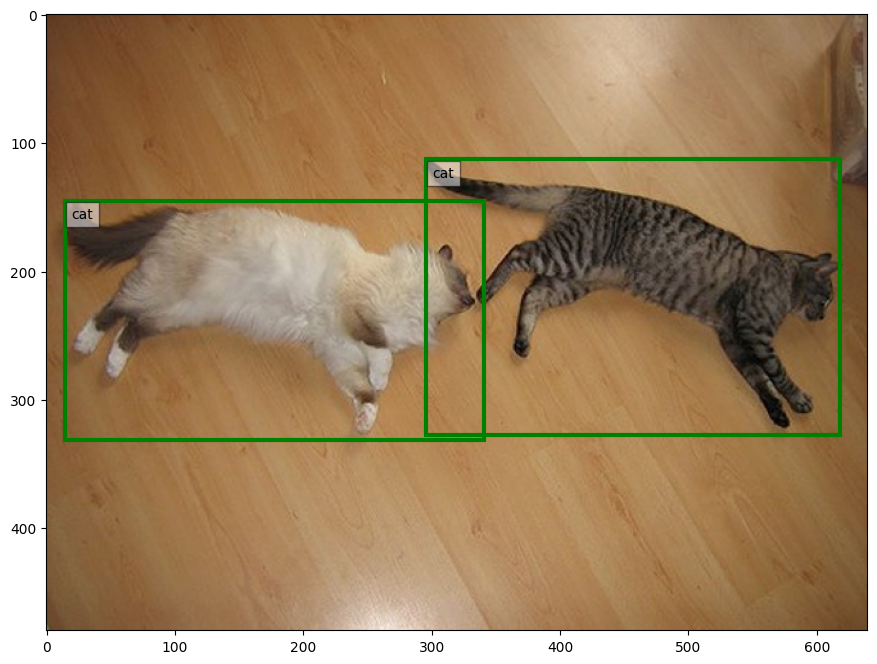

In [14]:
eval_idx = 4
show_train = False
if show_train:
    data_tv = data_train
else:
    data_tv = data_val
# id_cats = {cat_ids[key]: key for key in cat_ids.keys()}                            # reverse the category ids
example_image = data_tv.images[eval_idx].long()                              # look up the image and convert to long
example_labels = [id2str[key] for key in data_tv.labels[eval_idx].tolist()] # get the actual label string(s)
example_bboxes = data_tv.bboxes[eval_idx]                                    # get this sample's bounding box(es) (format is: [x_min, y_min, x_max, y_max])
ImageUtil.build_image(example_image, example_bboxes, example_labels, 'g')

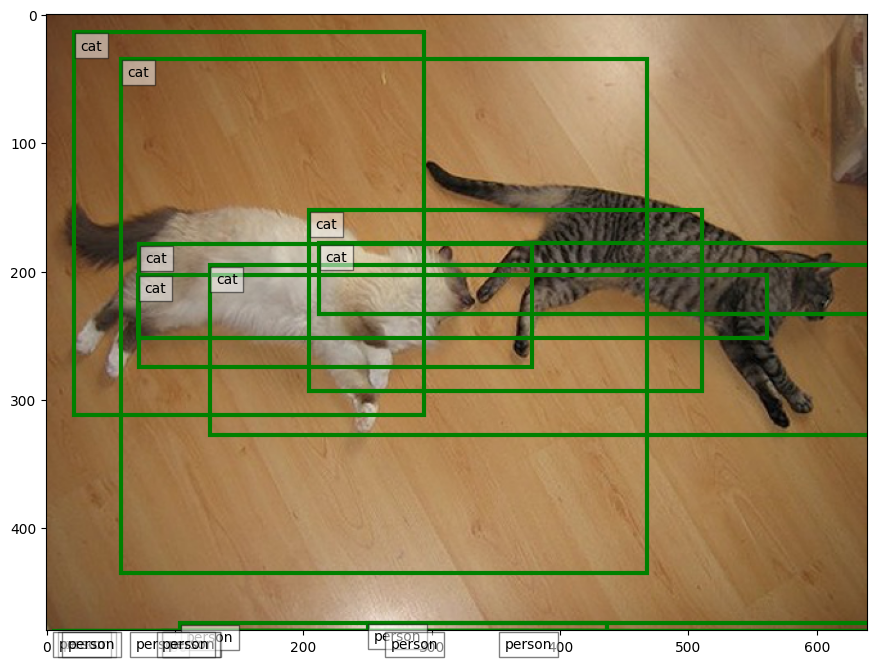

In [15]:
eval_labels = [id2str[key] for key in labels[eval_idx].tolist()] # get the actual label string(s)
eval_bboxes = proposals[eval_idx]                                    # get this sample's bounding box(es) (format is: [x_min, y_min, x_max, y_max])
ImageUtil.build_image(example_image, eval_bboxes, eval_labels, 'g')

## Step 1d. Comparison Against Other Pre-Trained Models

In [ ]:
# # code is adapted from: https://pytorch.org/vision/stable/models.html

# from torchvision.models.detection import fasterrcnn_resnet50_fpn, FasterRCNN_ResNet50_FPN_Weights

# # initialize weights
# weights = FasterRCNN_ResNet50_FPN_Weights.DEFAULT

# # initialize model
# fpn_model = fasterrcnn_resnet50_fpn(weights=weights)

# # transform the input images
# preprocess = weights.transforms()
# image_set = [preprocess(image) for image in x_train]

# # evaluate the images
# output = fpn_model(image_set)

# # interpret the labels (bounding boxes live in output["boxes"])
# labels = [weights.meta["categories"][i] for i in output["labels"]]